In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")

import tensorflow as tf
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.15.0
GPU detected: []


In [ ]:
#Loading data
data= pd.read_csv("https://raw.githubusercontent.com/yrnigam/Named-Entity-Recognition-NER-using-LSTMs/master/ner_dataset.csv",encoding="latin1")

In [ ]:
#Looking for null values
print(data.isnull().sum())

Sentence #    1000616
Word                0
POS                 0
Tag                 0
dtype: int64


In [ ]:
#Filling Null Values
data = data.fillna(method='ffill')
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [ ]:
print("Unique Words in corpus:",data['Word'].nunique())
print("Unique Tag in corpus:",data['Tag'].nunique())

Unique Words in corpus: 35178
Unique Tag in corpus: 17


In [ ]:
#Storing unique words and tags as a list
words = list(set(data['Word'].values))
words.append("ENDPAD")
num_words = len(words)

In [ ]:
tags = list(set(data['Tag'].values))
num_tags = len(tags)

In [ ]:
num_words, num_tags

(35179, 17)

In [ ]:
#Creating a class to get data in desired formate. i.e. Word,POS,Tag
class SentanceGetter(object):
  def __init__(self,data):
    self.n_sent = 1 #counter
    self.data = data
    agg_func = lambda s:[(w,p,t) for w,p,t in zip(s['Word'].tolist(),s['POS'].tolist(),s['Tag'].tolist())]
    self.grouped = self.data.groupby("Sentence #").apply(agg_func)
    self.sentances = [s for s in self.grouped]

In [ ]:
getter = SentanceGetter(data)
sentances = getter.sentances

In [ ]:
sentances[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

In [ ]:
word2idx =  {w : i+1 for i,w in enumerate(words)}
tag2idx  =  {t : i for i,t in enumerate(tags)}

In [ ]:
word2idx

{'wiretapped': 1,
 'Konarak': 2,
 'over-threw': 3,
 'Golovin': 4,
 '5,49,000': 5,
 '13.65': 6,
 'book-signing': 7,
 'remixed': 8,
 'interethnic': 9,
 'hostile': 10,
 'SBS': 11,
 'Etihad': 12,
 'culled': 13,
 'forgetting': 14,
 'Guttenberg': 15,
 'gallows': 16,
 'transplant': 17,
 'cereal': 18,
 'intends': 19,
 'Canada-US': 20,
 'leftist': 21,
 'Priscilla': 22,
 'shook': 23,
 'energy': 24,
 'Royals': 25,
 'lengthy': 26,
 'apologise': 27,
 'indicators': 28,
 'Neo': 29,
 'nest': 30,
 'cull': 31,
 'Larkin': 32,
 'Beatrice': 33,
 'Ilam': 34,
 '450-member': 35,
 'al-Rai': 36,
 'traveller': 37,
 'Embera': 38,
 'pears': 39,
 'endure': 40,
 'Emroz': 41,
 'ill-fated': 42,
 'pop': 43,
 'Cauvin': 44,
 'Indian': 45,
 'Tegucigalpa': 46,
 'perished': 47,
 'swells': 48,
 'occurring': 49,
 'Ladi': 50,
 'Woo-ik': 51,
 'demotions': 52,
 'hearings': 53,
 'Presidency': 54,
 'dance': 55,
 'legally': 56,
 'deity': 57,
 'destined': 58,
 'Viera': 59,
 'diners': 60,
 'stagnation': 61,
 'surroundings': 62,
 'Leo

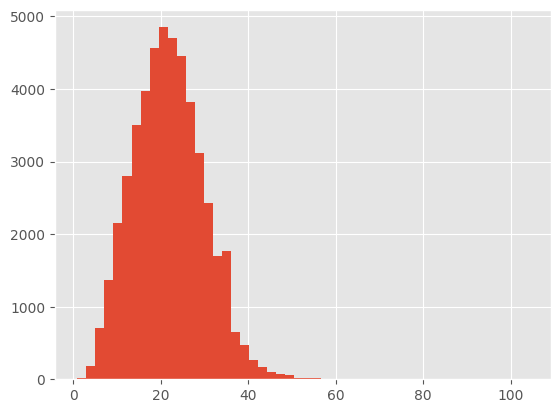

In [ ]:
plt.hist([len(s) for s in sentances], bins=50)
plt.show()

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

max_len = 50

X = [[word2idx[w[0]] for w in s]for s in sentances]
X = pad_sequences(maxlen = max_len , sequences =X, padding='post', value =num_words-1)

y = [[tag2idx[w[2]] for w in s]for s in sentances]
y = pad_sequences(maxlen = max_len , sequences =y, padding='post', value =tag2idx["O"])
y = [to_categorical(i, num_classes=num_tags) for i in y]

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(X,y, test_size=0.1, random_state=1)

In [ ]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [ ]:
input_word = Input(shape = (max_len,))
model = Embedding(input_dim=num_words,output_dim=max_len,input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags,activation='softmax'))(model)
model = Model(input_word,out)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 50)            1758950   
                                                                 
 spatial_dropout1d (Spatial  (None, 50, 50)            0         
 Dropout1D)                                                      
                                                                 
 bidirectional (Bidirection  (None, 50, 200)           120800    
 al)                                                             
                                                                 
 time_distributed (TimeDist  (None, 50, 17)            3417      
 ributed)                                                        
                                                             

In [ ]:
model.compile(optimizer="adam",loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
!pip install livelossplot

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

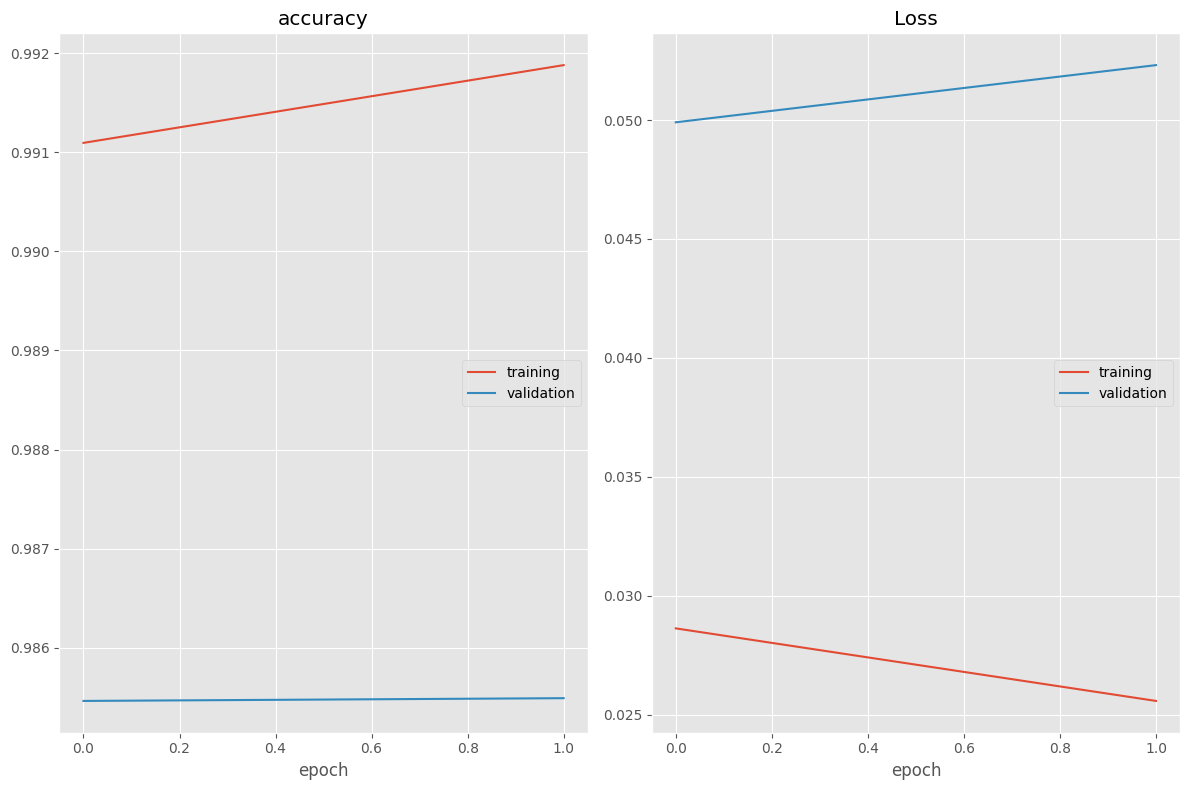

accuracy
	training         	 (min:    0.991, max:    0.992, cur:    0.992)
	validation       	 (min:    0.985, max:    0.985, cur:    0.985)
Loss
	training         	 (min:    0.026, max:    0.029, cur:    0.026)
	validation       	 (min:    0.050, max:    0.052, cur:    0.052)
540/540 [==============================] - 158s 292ms/step - loss: 0.0256 - accuracy: 0.9919 - val_loss: 0.0523 - val_accuracy: 0.9855


In [ ]:
early_stopping = EarlyStopping(monitor='val_accuracy',patience=1,verbose=0,mode='max',restore_best_weights=False)
callbacks = [PlotLossesCallback(),early_stopping]

history = model.fit(
    x_train,np.array(y_train),
    validation_split = 0.2,
    batch_size = 64,
    epochs = 2,
    verbose = 1,
    callbacks=callbacks
)

In [ ]:
import numpy as np

def predict_and_print(model, x_test, y_test, words, tags):
    i = np.random.randint(0, x_test.shape[0])
    p = model.predict(np.array([x_test[i]]))
    p = np.argmax(p, axis=-1)

    y_true = np.argmax(np.array(y_test), axis=-1)[i]
    print("{:15}{:5}\t {}\n".format("Word","True","Pred"))
    print("-"*30)
    for w,true,pred in zip(x_test[i], y_true, p[0]):
        print("{:15}{:5}\t{}".format(words[w-1], tags[true], tags[pred]))

# Call the function twice
predict_and_print(model, x_test, y_test, words, tags)
predict_and_print(model, x_test, y_test, words, tags)


1/1 [==============================] - 0s 32ms/step
Word           True 	 Pred

------------------------------
After          O    	O
several        B-tim	O
weeks          O    	O
of             O    	O
almost         O    	O
non-stop       O    	O
travel         O    	O
,              O    	O
President      B-per	B-per
Bush           I-per	I-per
is             O    	O
spending       O    	O
the            O    	O
holiday        O    	O
at             O    	O
his            O    	O
ranch          O    	O
in             O    	O
Crawford       B-geo	B-geo
,              O    	O
Texas          B-geo	B-geo
to             O    	O
spend          O    	O
a              O    	O
few            O    	O
quiet          O    	O
days           O    	O
with           O    	O
his            O    	O
family         O    	O
.              O    	O
stopped        O    	O
stopped        O    	O
stopped        O    	O
stopped        O    	O
stopped        O    	O
stopped        O    	O
stopped        O    	O